In [1]:
import os
import torch
import torchaudio
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchaudio.datasets import GTZAN
from torch.utils.data import DataLoader
import torchaudio.transforms as tt
from torch.utils.data import random_split
import matplotlib
import matplotlib.pyplot as plt
import gc
from sklearn.metrics import accuracy_score, confusion_matrix
import torch.nn.functional as F
from torch.utils.data import DataLoader
import IPython
from tqdm import tqdm

%matplotlib inline

device = torch.device(
    'mps:0' if torch.backends.mps.is_available() else 'cuda:0' if torch.cuda.is_available() else 'cpu'
    )

device


device(type='mps', index=0)

In [2]:
data_dir='data/genres_5sec/'
list_files=os.listdir(data_dir)
classes=[]
for file in list_files:
  name='{}/{}'.format(data_dir,file)
  if os.path.isdir(name):
    classes.append(file)
classes


['pop',
 'metal',
 'disco',
 'blues',
 'reggae',
 'classical',
 'rock',
 'hiphop',
 'country',
 'jazz']

In [3]:
samplerate=22050
def parse_genres(fname):
    parts = fname.split('/')[-1].split('.')[0]
    return parts #' '.join(parts[0])

class MusicDataset(Dataset):
    def __init__(self, root):
        super().__init__()
        self.root = root
        self.files =[]
        for c in classes:
          self.files = self.files + [fname for fname in os.listdir(os.path.join(root,c)) if fname.endswith('.wav')]
        self.classes = list(set(parse_genres(fname) for fname in self.files))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, i):
        fname = self.files[i]

        #img = self.transform(open_image(fpath))
        genre = parse_genres(fname)
        fpath = os.path.join(self.root,genre, fname)
        class_idx = self.classes.index(genre)
        audio = torchaudio.load(fpath)[0]

        hop_length = 432
        n_mels = 512
        n_fft = 2*(n_mels - 1)
        spectogram = tt.Spectrogram(
            n_fft=n_fft,
            hop_length=hop_length,
        )(audio)

        # MelSpectrogram tt.MelSpectrogram(sample_rate=samplerate, n_fft=1024, hop_length=512, n_mels=128)(audio)
        # mel_spectogram = tt.MelSpectrogram(sample_rate=samplerate, n_fft=1024, hop_length=200, n_mels=201)(audio)
                
        hop_length=432
        n_mels=256
        n_fft = 2*(n_mels - 1)
        
        mel_spectogram = tt.MelSpectrogram(sample_rate=samplerate, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)(audio)
        
        return audio, spectogram, mel_spectogram, class_idx
    
    def __repr__(self):
        fmt_str = 'Dataset ' + self.__class__.__name__ + '\n'
        fmt_str += '    Number of datapoints: {}\n'.format(self.__len__())
        fmt_str += '    Root Location: {}\n'.format(self.root)
        # List classes
        fmt_str += '    Classes: {}\n'.format(self.classes)
        return fmt_str

dataset = MusicDataset(data_dir)

random_seed = 42
torch.manual_seed(random_seed);
val_size = 100
test_size = 100
train_size = len(dataset) - val_size - test_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds), len(val_ds), len(test_ds)

batch_size = 10

train_dl = DataLoader(train_ds, batch_size, shuffle=True, pin_memory=True)
valid_dl = DataLoader(val_ds, batch_size*2, pin_memory=True)
test_dl = DataLoader(test_ds, 1, pin_memory=True)

dataset


Dataset MusicDataset
    Number of datapoints: 990
    Root Location: data/genres_5sec/
    Classes: ['reggae', 'country', 'rock', 'blues', 'pop', 'disco', 'metal', 'classical', 'hiphop', 'jazz']

torch.Size([1, 1, 110250])


/Users/nacho/Desktop/code/TP4_TDVI/.conda/lib/python3.10/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(


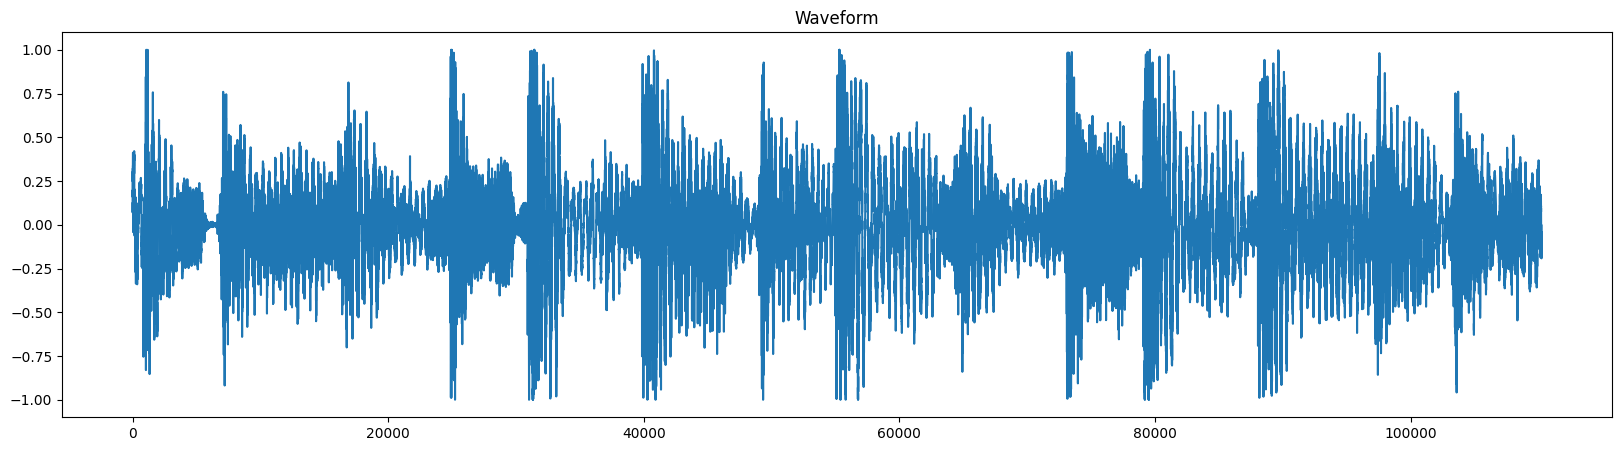

In [4]:
waveform, spectogram, mel_spectogram, label = next(iter(test_dl))
spec = spectogram.to(device)

test_spec_sample = spec
test_wf_sample = waveform

fig, ax = plt.subplots(1, figsize=(20, 5))

ax.plot(waveform[0][0].numpy())
ax.set_title("Waveform")

print(waveform.size())
IPython.display.Audio(test_wf_sample[0].cpu().numpy(), rate=samplerate)


In [5]:
# Get all the files
files = os.listdir("train_out/wavs/")
files = [file for file in files if file.endswith(".npy")]


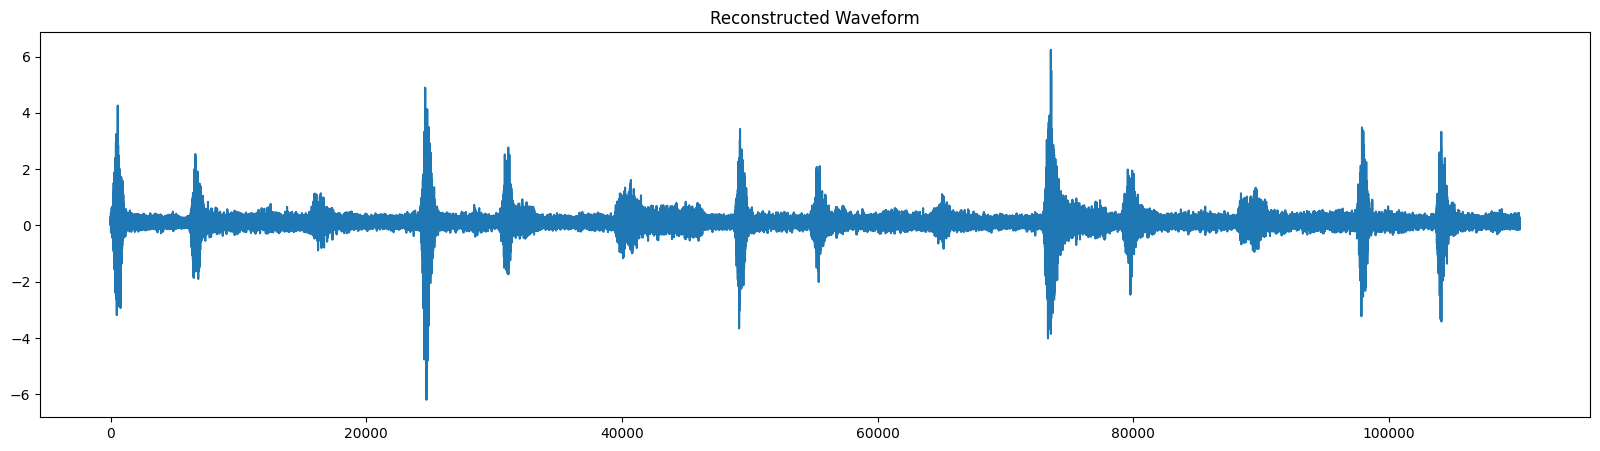

In [22]:
rec_wav = np.load("train_out/wavs/" + files[0])[0]

fig, ax = plt.subplots(1, figsize=(20, 5))
ax.plot(rec_wav[0])
ax.set_title("Reconstructed Waveform")

IPython.display.Audio(rec_wav, rate=samplerate)


Text(0.5, 1.0, 'Reconstructed Waveform')

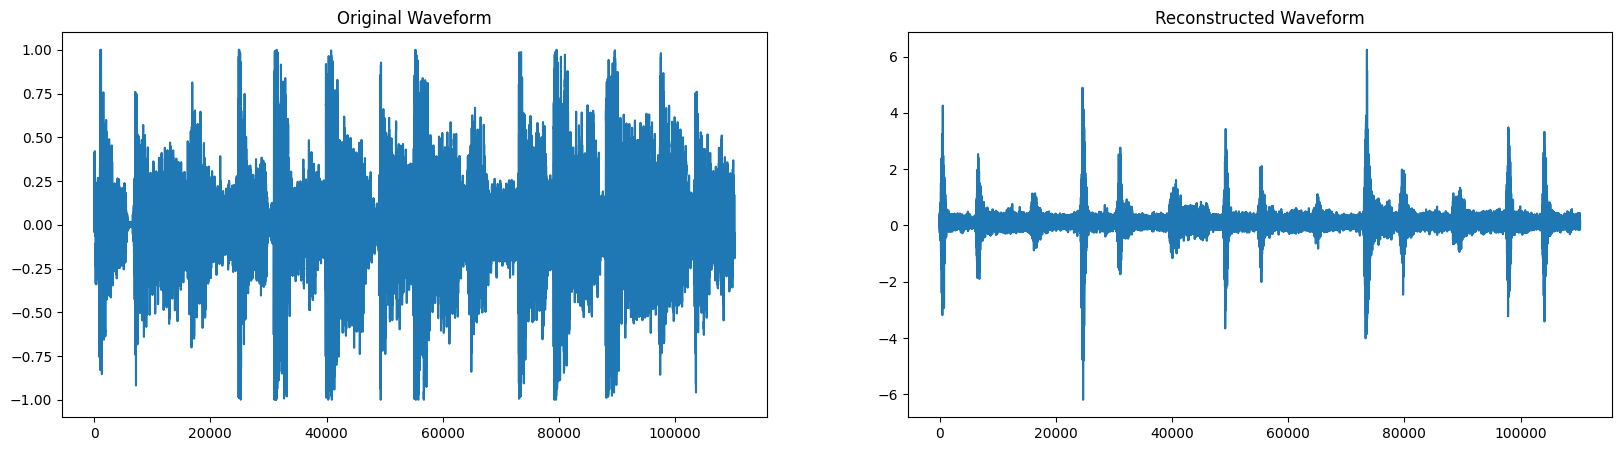

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

axs[0].plot(waveform[0][0].numpy())
axs[0].set_title("Original Waveform")

axs[1].plot(rec_wav[0])
axs[1].set_title("Reconstructed Waveform")


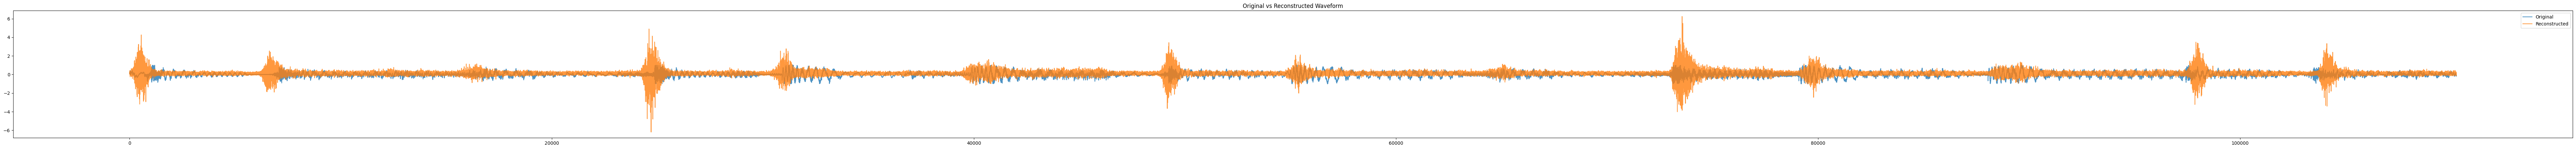

In [29]:
fig, ax = plt.subplots(1, figsize=(100, 5))

ax.plot(waveform[0][0].numpy(), label="Original", alpha=0.8)
ax.plot(rec_wav[0], label="Reconstructed", alpha=0.8)

ax.set_title("Original vs Reconstructed Waveform")

ax.legend()

# save as pdf

fig.savefig("train_out/waveform.pdf", bbox_inches='tight')
